In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Summary
This notebook opens up the NOBM-OASIM dataset and creates IOP ratios and normalizes Rrs. It decomposes the normalized Rrs spectra using PCA loadings to calculate the principal components (scores). Each PC score is added as new dimension to dataset and saved as a new .netcdf

# Read in dataset

In [21]:
rrs_xds = xr.open_dataset('/glusteruser/awindled/all_NOBM_OASIM_data_2020.nc', decode_times=False)
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/42)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    coc_a           (wavelength, months, lat, lon) float32 ...
    coc_bb          (wavelength, months, lat, lon) float32 ...
    cdoc_a          (wavelength, months, lat, lon) float32 ...
    det_a           (wavelength, months, lat, lon) float32 ...
    det_bb          (wavelength, months, lat, lon) float32 ...
    pic_bb          (wavelength, months, lat, lon) float32 ...

# Calculate and add IOP ratios

In [31]:
#ratio as an index of flattening of the spectra 
rrs_xds['aph440_aph676'] = rrs_xds.total_phy_a[90,:,:,:] / rrs_xds.total_phy_a[326,:,:,:]

#estimate of the contribution of phytoplankton to the total pool of particles
rrs_xds['aph440_ap440'] = rrs_xds.total_phy_a[90,:,:,:] / rrs_xds.particulate_a[90,:,:,:]
#GIOP doesn't produce ap

#cdom absorption at 443
rrs_xds['a_cdoc_443'] = rrs_xds.cdoc_a[93,:,:,:]
#GIOP only produces adg_s 

#bbp slope using 440 and 555
rrs_xds['bbp_s_440_555'] = rrs_xds.particulate_bb[90,:,:,:] / rrs_xds.particulate_bb[205,:,:,:]

#bbp/bp - sensitive to particulate composition 
rrs_xds['bbp_bp_555'] = rrs_xds.total_phy_bb[205,:,:,:] / rrs_xds.particulate_bb[205,:,:,:] 
# GIOP doesn't produce scattering

#ap/bbp- how much attenuated/absorbed vs scattered. bigger particles scatter more ?
rrs_xds['a_bb_555'] = rrs_xds.total_phy_a[205,:,:,:] / rrs_xds.total_phy_bb[205,:,:,:]

rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/49)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    aph440_ap440    (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    a_cdoc_443      (months, lat, lon) float32 ...
    bbp_s_440_555   (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    rrs_norm        (wavelength, months, lat, lon) float64 nan nan ... nan nan
    a_bb_555        (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    bbp_bp_555      (months, lat, lon) float32 nan nan nan nan ... nan nan nan

# Normalize rrs and add as new variable

In [32]:
rrs_xds['rrs_norm'] = (rrs_xds.rrs - rrs_xds.rrs.mean()) / rrs_xds.rrs.std()
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/49)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    aph440_ap440    (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    a_cdoc_443      (months, lat, lon) float32 ...
    bbp_s_440_555   (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    rrs_norm        (wavelength, months, lat, lon) float64 nan nan ... nan nan
    a_bb_555        (months, lat, lon) float32 nan nan nan nan ... nan nan nan
    bbp_bp_555      (months, lat, lon) float32 nan nan nan nan ... nan nan nan

# Prediction of U (scores) of samples using the V (loadings) of training PCA

In [33]:
# Load PCA loadings (calculated elsewhere) 
loadings_trun = pd.read_csv('/glusteruser/awindled/loadings_trun.csv', index_col=0) 
loadings_trun

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.055005,0.055595,0.056184,0.056776,0.057372,0.057974,0.058585,0.059204
1,-0.049796,-0.049860,-0.049911,-0.049952,-0.049987,-0.050018,-0.050051,-0.050215
2,0.098926,0.098782,0.098637,0.098496,0.098354,0.098211,0.098068,0.097807
3,-0.120409,-0.119454,-0.118471,-0.117459,-0.116416,-0.115342,-0.114230,-0.113238
4,0.123148,0.121144,0.119051,0.116859,0.114560,0.112167,0.109646,0.105997
...,...,...,...,...,...,...,...,...
396,0.006164,-0.000132,0.003332,-0.001595,0.000212,-0.005240,-0.000307,-0.002313
397,-0.001991,0.002591,0.001718,-0.001795,0.000579,-0.003002,0.000490,0.000445
398,0.003266,0.004642,0.002250,-0.003100,-0.004262,-0.000818,-0.003591,-0.000376
399,-0.002043,-0.000110,-0.001774,0.004298,-0.000565,0.003607,0.002535,-0.000262


In [34]:
#Have to stack and transpose dataset for calculation
rrs_xds_norm_stacked = rrs_xds.rrs_norm.stack(z=("months", "lat", "lon")).T
rrs_xds_norm_stacked

<xarray.DataArray 'rrs_norm' (z: 808704, wavelength: 401)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * wavelength  (wavelength) int64 350 351 352 353 354 ... 746 747 748 749 750
    wv          (wavelength) int64 ...
  * z           (z) object MultiIndex
  * months      (z) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 11.0 11.0 11.0 11.0 11.0
  * lat         (z) float32 -84.0 -84.0 -84.0 -84.0 ... 71.33 71.33 71.33 71.33
  * lon         (z) float32 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8

In [35]:
#these are called scores!!!!

In [36]:
%%time
## Prediction of U (scores) of samples using the V (loadings) 
#of the training PCA

r_sum = []
for j in range(len(loadings_trun)):
    for i in range(len(rrs_xds_norm_stacked)):
        r = loadings_trun.iloc[:,j] * rrs_xds_norm_stacked[i,:].values
        r_sum.append(np.sum(r))

IndexError: single positional indexer is out-of-bounds

In [37]:
len(r_sum)

6469632

In [38]:
6469632/808704

8.0

In [39]:
#create table of scores for each Rrs spectra (pixel)
RrsU_mod = [r_sum[x:x+808704] for x in range(0, len(r_sum),808704)]
RrsU_mod = pd.DataFrame(np.array(RrsU_mod)).T
RrsU_mod = RrsU_mod.set_axis(loadings_trun.columns, axis=1)
RrsU_mod 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
808699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# save RrsU_mod as .csv 

In [40]:
#RrsU_mod.to_csv('/glusteruser/awindled/RrsU_mod.csv')

RrsU_mod = pd.read_csv('/glusteruser/awindled/RrsU_mod.csv').iloc[:,1:]
RrsU_mod

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
808699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
808702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Reshape RrsU_mod and add each EOF modes as variable to dataset

In [41]:
RrsU_mod_reshape = RrsU_mod.values.reshape(12, 234, 288, 8)
RrsU_mod_reshape.shape

(12, 234, 288, 8)

In [42]:
for i in range(len(RrsU_mod.columns)):
    rrs_xds['EOF_'+str(i+1)] = xr.DataArray(RrsU_mod_reshape[:,:,:,i], dims=('months', 'lat', 'lon'))
rrs_xds    

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/57)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    EOF_3           (months, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EOF_4           (months, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EOF_5           (months, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EOF_6           (months, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EOF_7           (months, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EOF_8           (months, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

# Save new dataset w/ score variables

In [43]:
xr.Dataset(rrs_xds).to_netcdf('/glusteruser/awindled/ALL_NOBM_OASIM_data_2020_w_EOF.nc', mode='w', format='NETCDF4')


In [47]:
print(rrs_xds.EOF_1.min())
print(rrs_xds.EOF_1.max())

print(rrs_xds.EOF_2.min())
print(rrs_xds.EOF_2.max())

print(rrs_xds.EOF_3.min())
print(rrs_xds.EOF_3.max())

print(rrs_xds.EOF_4.min())
print(rrs_xds.EOF_4.max())

<xarray.DataArray 'EOF_1' ()>
array(0.)
<xarray.DataArray 'EOF_1' ()>
array(2.05062105)
<xarray.DataArray 'EOF_2' ()>
array(-0.74540502)
<xarray.DataArray 'EOF_2' ()>
array(0.70436827)
<xarray.DataArray 'EOF_3' ()>
array(-1.4781114)
<xarray.DataArray 'EOF_3' ()>
array(0.05331275)
<xarray.DataArray 'EOF_4' ()>
array(-1.01558621)
<xarray.DataArray 'EOF_4' ()>
array(0.40072681)


(array([3.2034e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.0000e+00, 8.7000e+01, 9.0000e+01, 2.0800e+02, 1.1300e+03,
        3.4120e+03, 7.3800e+03, 1.1011e+04, 1.1978e+04, 1.2869e+04,
        2.0641e+04, 3.1046e+04, 4.6482e+04, 6.1474e+04, 6.8475e+04,
        6.0808e+04, 6.2879e+04, 6.5264e+04, 2.1818e+04, 9.6200e+02,
        1.7100e+02, 8.4000e+01, 5.1000e+01, 2.2000e+01, 1.1000e+01,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.04101242, 0.08202484, 0.12303726, 0.16404968,
        0.2050621 , 0.24607453, 0.28708695, 0.32809937, 0.36911179,
        0.41012421, 0.45113663, 0.49214905, 0.53316147, 0.57417389,
        0.61518631, 0.65619873, 0.69721116, 0.73822358, 0.779236  ,
        0.82024842, 0.86126084, 0.90227326, 0.

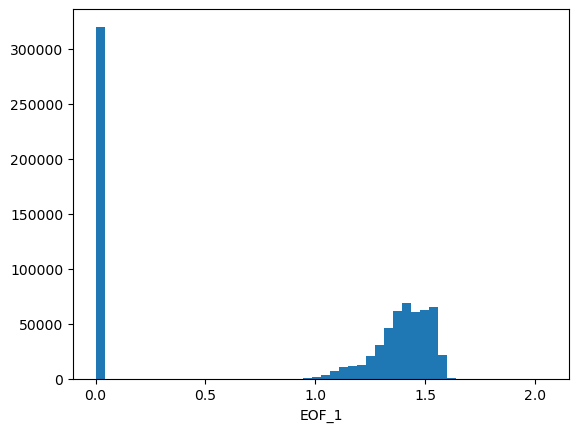

In [51]:
rrs_xds.EOF_1.plot.hist(bins=50)

(array([3.20000e+01, 6.20000e+01, 5.30000e+01, 8.00000e+01, 2.51000e+02,
        8.54000e+02, 1.86600e+03, 3.70700e+03, 5.44600e+03, 6.84300e+03,
        7.53700e+03, 7.54600e+03, 7.71400e+03, 9.19300e+03, 1.40430e+04,
        1.78710e+04, 2.29270e+04, 2.96320e+04, 3.45040e+04, 3.94270e+04,
        4.09280e+04, 3.93320e+04, 3.59250e+04, 3.54850e+04, 3.58330e+04,
        3.58015e+05, 3.17770e+04, 1.76580e+04, 3.26400e+03, 3.81000e+02,
        1.62000e+02, 7.70000e+01, 7.00000e+01, 6.50000e+01, 3.60000e+01,
        3.90000e+01, 2.60000e+01, 1.40000e+01, 8.00000e+00, 6.00000e+00,
        6.00000e+00, 7.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-0.74540502, -0.71640955, -0.68741409, -0.65841862, -0.62942316,
        -0.60042769, -0.57143223, -0.54243676, -0.51344129, -0.48444583,
        -0.45545036, -0.4264549 , -0.39745943, -0.36846396, -0.3394685 ,
        -0.31047303, -0.28147757, -0.2524821 , -0

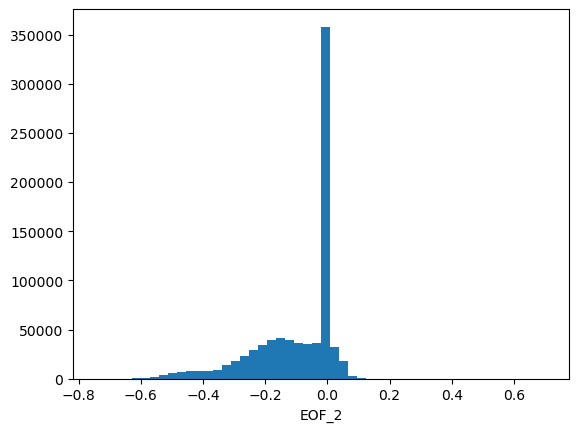

In [52]:
rrs_xds.EOF_2.plot.hist(bins=50)